# Trump Tweet Analysis

In [1]:
import re
import numpy as np
import pandas as pd
import timeit
import string
import gensim
import pickle
import nltk
from gensim import models, corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['amp','rt','u']
wn = WordNetLemmatizer()

df = pd.read_csv('TrumpTweet.csv')
df2 = df[df['is_retweet']==False][['created_at','text']]
doc_full = df2['text'].to_list()

In [2]:
print("Number of Tweet: {}".format(len(df2)))

Number of Tweet: 25963


# Clean data and prepocess

In [3]:
def tweet_cleaner2(text):
    # remove mention
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # remove website
    text = re.sub(r'https?://[A-Za-z0-9./]+', '',text)
    # remove non-ASCII
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # nlp preprocessing
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    text = bigram_mod[text]
    text = [wn.lemmatize(word) for word in text]
    text = [word for word in text if len(word) >1]
    return text

start = timeit.default_timer()
# bigram mode
bigram = gensim.models.Phrases([i.split() for i in doc_full], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
# clean data
doc_clean = [tweet_cleaner2(doc) for doc in doc_full]
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  9.580230194


# Create corpus and dictionary

In [4]:
id2word = corpora.Dictionary(doc_clean)
id2word.filter_extremes(no_below=5)
corpus = [id2word.doc2bow(doc) for doc in doc_clean]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
mallet_path = 'mallet-2.0.8/bin/mallet'

# Tune LDA Mallet Model

In [6]:
score_list = []
ldamallet_models = []
for num_topics in tnrange(5,20):
    print ('No. topics: {}'.format(num_topics))
    ldamodel = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                corpus=corpus_tfidf, 
                                                num_topics=num_topics, 
                                                id2word=id2word)
    coherence_model_lda = CoherenceModel(model=ldamodel, 
                                        texts=doc_clean, 
                                        dictionary=id2word, 
                                        coherence='c_v')
    score = coherence_model_lda.get_coherence()
    score_list.append(score)
    print('Score: {}'.format(score))
    ldamallet_models.append(ldamodel)

  0%|          | 0/15 [00:00<?, ?it/s]

No. topics: 5
Score: 0.643726191180821
No. topics: 6
Score: 0.6628363929422334
No. topics: 7
Score: 0.6414134119525341
No. topics: 8
Score: 0.6496130750182479
No. topics: 9
Score: 0.6233919936718341
No. topics: 10
Score: 0.6361282016199561
No. topics: 11
Score: 0.6559705234890753
No. topics: 12
Score: 0.6582133897623073
No. topics: 13
Score: 0.6379330096593782
No. topics: 14
Score: 0.6555442189087669
No. topics: 15
Score: 0.6585796161902702
No. topics: 16
Score: 0.6729373617582023
No. topics: 17
Score: 0.6832940764966013
No. topics: 18
Score: 0.6772402531002167
No. topics: 19
Score: 0.687796679449636


# Optimal Model

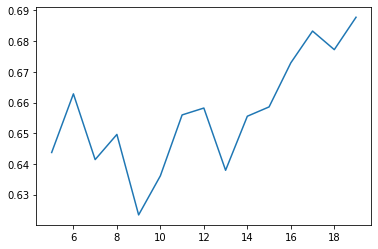

In [7]:
X = [i for i in range(5,20)]

fig, ax = plt.subplots()
ax.plot(X, score_list)

Model have 6 topics have high score and less topic

In [29]:
lda_model = ldamallet_models[1]

# Results

In [30]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=20)] 
          for n in range(0, lda_model.num_topics)]

In [36]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df.to_csv('model_topics.csv')
topics_df

<ipython-input-36-90961a8a7af7>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"true, obamagate, nice, vote, unga, back, tear, salutetoamerica, whistleblower, part, 1000, memorialday, rigged, trumptrain, support, catch, jay, give, shame, big"
Topic2,"job, agree, enjoy, terrible, maga, social_distancing, promise, unbelievable, report, trump, pathetic, ridiculous, iacaucus, movement, winning, proclamation, pressure, definition, chance, electionday"
Topic3,"congratulation, makeamericagreatagain, penny, weeklyaddress, interesting, bigleaguetruth, socialmediasummit, dday75thanniversary, correct, crime, florida, liar, weekly, jail, 19, patriot, 2020, treason, holy, loser"
Topic4,"fake_news, amazing, neverforget, trump2016, watch, jordan, jobsnotmobs, sad, warrior, voter_fraud, economy, response, disgrace, winner, debate, americafirst, good, stand, bernie, nasty"
Topic5,"wow, crookedhillary, happy, justice, kag2020, sotu, draintheswamp, votetrump, rncincle, love, climate, admission, brandon, witchhunt, time, fact, begun, totally, resource, mueller"
Topic6,"great, usa, tune, disgraceful, obamacarefail, imwithyou, crazy, boring, deserved, veto, day, lol, awesome, ar, big, stop, choice, unfair, flashback, agree"


In [32]:
# getting topic for each document
tm_results = lda_model[corpus_tfidf]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [37]:
corpus_topics

[(0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 (0, 0.16666666666666669),
 

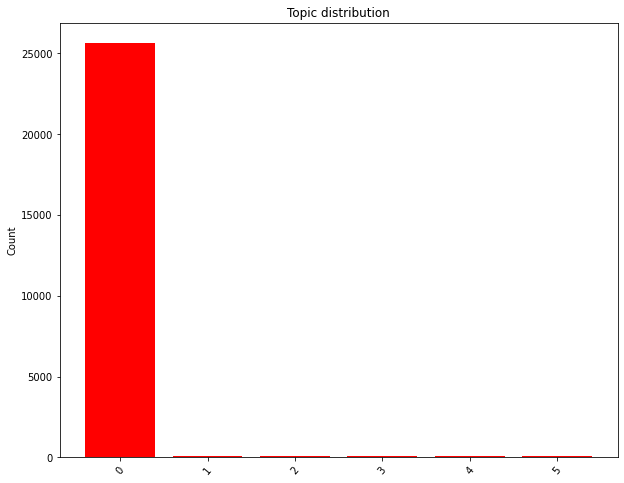

In [33]:
x = [str(i) for i in range(len(topics_df))]
y = []
for i in range(len(topics_df)):
    # getting topic text
    topic_index = [j for j, value in enumerate(corpus_topics) if value[0] == i]
    y.append(len(topic_index))

plt.figure(figsize=[10,8])
plt.bar(x, y, color='red')
plt.ylabel("Count")
plt.title("Topic distribution")
plt.xticks(rotation=50)
plt.show()

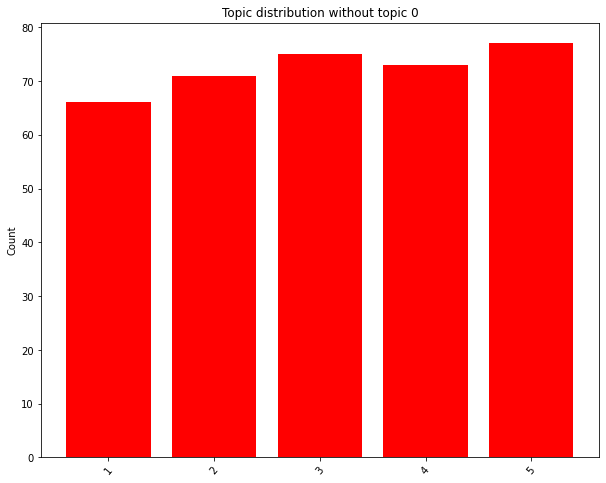

In [34]:
# without Topic 0 
plt.figure(figsize=[10,8])
plt.bar(x[1:], y[1:], color='red')
plt.ylabel("Count")
plt.title("Topic distribution without topic 0")
plt.xticks(rotation=50)
plt.show()

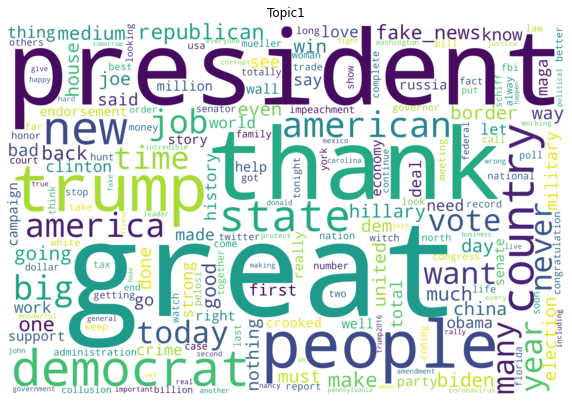

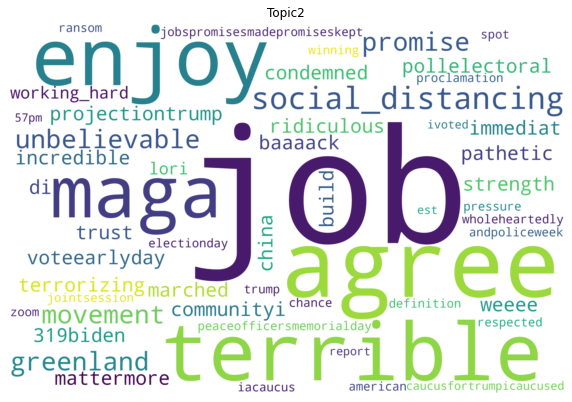

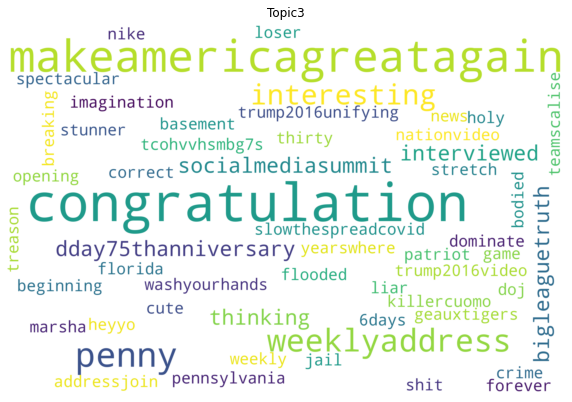

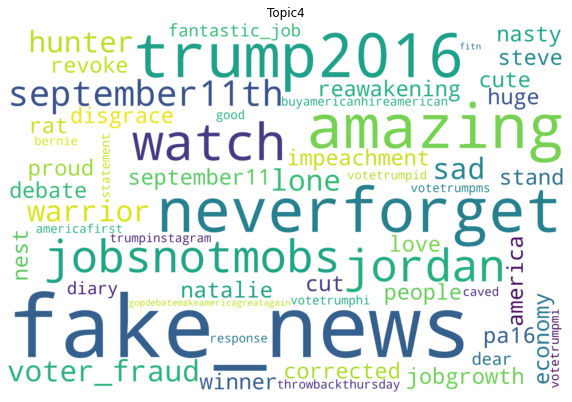

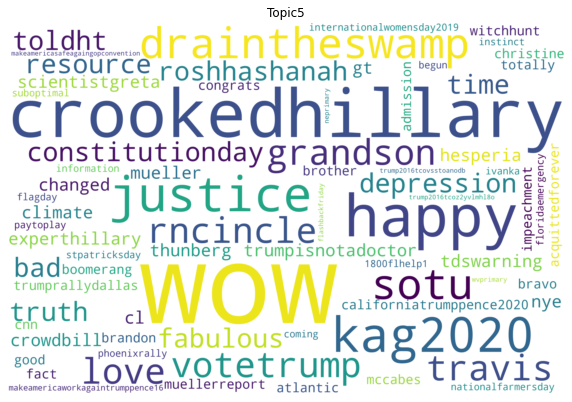

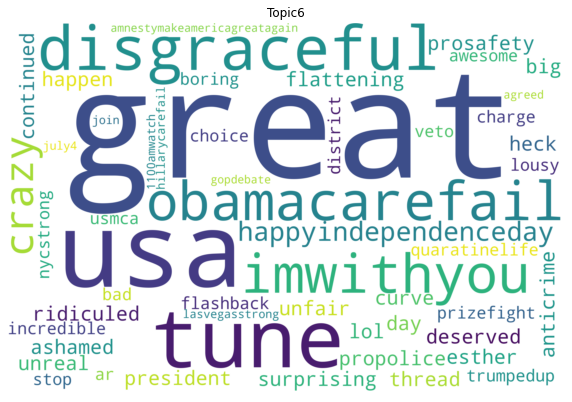

In [35]:
# initiate wordcloud object
wc = WordCloud(width = 3000, 
               height = 2000,
               background_color="white", 
               collocations=False,
               random_state=42)

# Create word cloud plots for each topic
for i in range(len(topics_df)):
    # getting topic text
    topic_index = [j for j, value in enumerate(corpus_topics) if value[0] == i]
    topic_text = [doc_clean[i] for i in topic_index]
    topic_text = [' '.join(topic_text[i]) for i in range(len(topic_text))]
    topic_text = ' '.join(topic_text)
    
    # plot
    wc.generate(text=topic_text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
    plt.show()
